In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle

import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

from visualization import *
from tools import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 199)

## Load or aggregate all tweets of known medias

In [7]:
RELOAD = False

DATA_PATH = "/mnt/datastore/data/coronavirus"
OUTPUT_PATH = "/mnt/datastore/data/tweets_medias.csv"
MEDIAS_PATH = "/mnt/datastore/data/top_twitter_medias.csv"
medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)

if RELOAD:
    cor_tweets_medias = aggregateTweets(DATA_PATH, authorsFilter=medias_accounts[0], savePath=OUTPUT_PATH)
else:
    cor_tweets_medias = pd.read_csv(OUTPUT_PATH)
    cor_tweets_medias['published'] = pd.to_datetime(cor_tweets_medias['published'], infer_datetime_format=True) 

### Dataset Summary

In [14]:
cor_tweets_medias.head()

,author_handle,lang,likes,main,permalink,published,replied,shared_type,shares,source_followers,source_following
0,coastaldigest,en,0.0,Second confirmed case of coronavirus reported in Kerala,https://twitter.com/coastaldigest/status/1223837532154028033,2020-02-02 05:16:20,False,NONE,0.0,2405.0,131.0
1,indiablooms,en,0.0,#Coronavirus outbreak: #Bangladesh halts visa-on-arrival for #Chinese nationals,https://twitter.com/indiablooms/status/1223971829481525248,2020-02-02 14:09:59,False,NONE,0.0,2236.0,2428.0
2,danwibg,en,0.0,"Coronavirus fears fuel racism and hostility, say British-Chinese",https://twitter.com/danwibg/status/1223969789590364160,2020-02-02 14:01:52,False,NONE,0.0,2915.0,1844.0
3,guardian,en,14.0,'Shameless': outrage in China over handling of coronavirus outbreak,https://twitter.com/guardian/status/1223979274232827910,2020-02-02 14:39:34,False,NONE,8.0,8250937.0,1080.0
4,WDTN,en,0.0,Butler County Health officials await results of coronavirus test,https://twitter.com/WDTN/status/1224079800106651649,2020-02-02 21:19:01,False,NONE,0.0,65933.0,470.0


In [24]:
cor_tweets_medias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55273 entries, 0 to 55272
Data columns (total 11 columns):
author_handle       55273 non-null object
lang                55273 non-null object
likes               55272 non-null float64
main                55273 non-null object
permalink           55273 non-null object
published           55273 non-null datetime64[ns]
replied             55273 non-null bool
shared_type         55273 non-null object
shares              55272 non-null float64
source_followers    55273 non-null float64
source_following    55273 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), object(5)
memory usage: 4.3+ MB


In [25]:
cor_tweets_medias.describe()

,likes,shares,source_followers,source_following
count,55272.000000,55272.000000,5.527300e+04,55273.000000
mean,6.339123,3.492419,1.546054e+06,2277.783800
std,50.454285,24.811462,4.547111e+06,7023.486007
min,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,3.853300e+04,248.000000
50%,1.000000,0.000000,1.992120e+05,688.000000
75%,3.000000,2.000000,1.058152e+06,1556.000000
max,6993.000000,2438.000000,5.630648e+07,113224.000000


### Volume of tweets

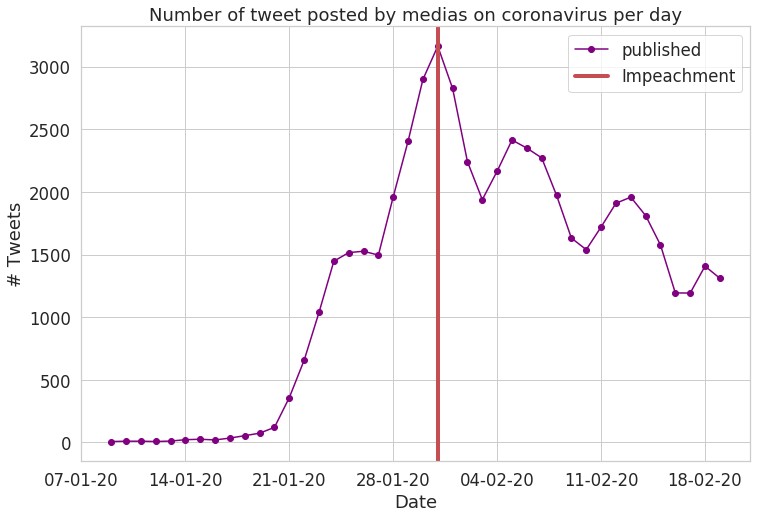

In [8]:
cor_tweets_medias_per_day = countByDay(cor_tweets_medias, "published")
title = "Number of tweet posted by medias on coronavirus per day"
plotTweetPerDay(cor_tweets_medias_per_day, title, rolling_window=3, 
                vertical_line_x="2020-01-31", vertical_line_label="Impeachment")

## Load or compute all tweets

In [4]:
RELOAD = False

DATA_PATH = "/mnt/datastore/data/coronavirus"
OUTPUT_PATH = "/mnt/datastore/data/tweets_users.csv"
MEDIAS_PATH = "/mnt/datastore/data/top_twitter_medias.csv"
medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)

if RELOAD:
    cor_tweets_users = aggregateTweets(DATA_PATH, authorsFilter=medias_accounts[0], authorsFilterKeep=False, columnsFilter="published", savePath=OUTPUT_PATH)
    cor_tweets_users = countByDay(cor_tweets_users, 'published')
    cor_tweets_users.to_csv("/mnt/datastore/data/tweets_users_per_day.csv", encoding='utf-8')
else:
    cor_tweets_users_per_day = pd.read_csv("/mnt/datastore/data/tweets_users_per_day.csv")
    cor_tweets_users_per_day['date'] = pd.to_datetime(cor_tweets_users_per_day['date'], infer_datetime_format=True) 



/home/fanfou/.local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


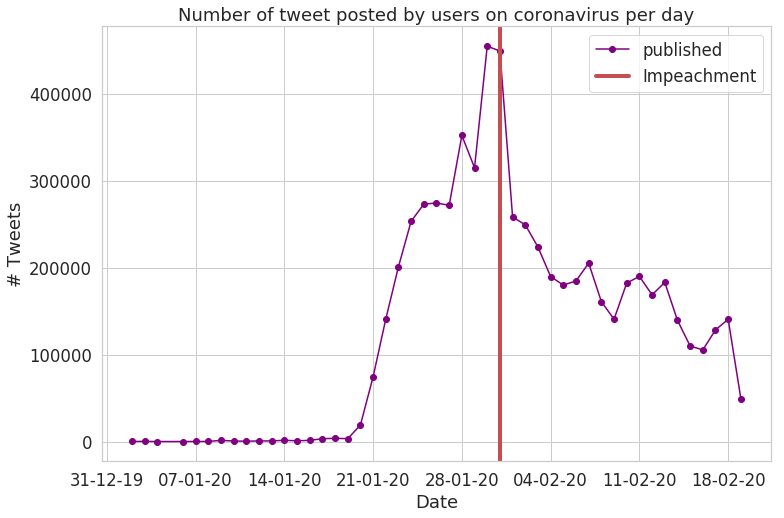

In [5]:
plotTweetPerDay(cor_tweets_users_per_day[cor_tweets_users_per_day['date'] > "2020-01-01"], "Number of tweet posted by users on coronavirus per day", 1,
               vertical_line_x="2020-01-31", vertical_line_label="Impeachment")

## Putting everything together

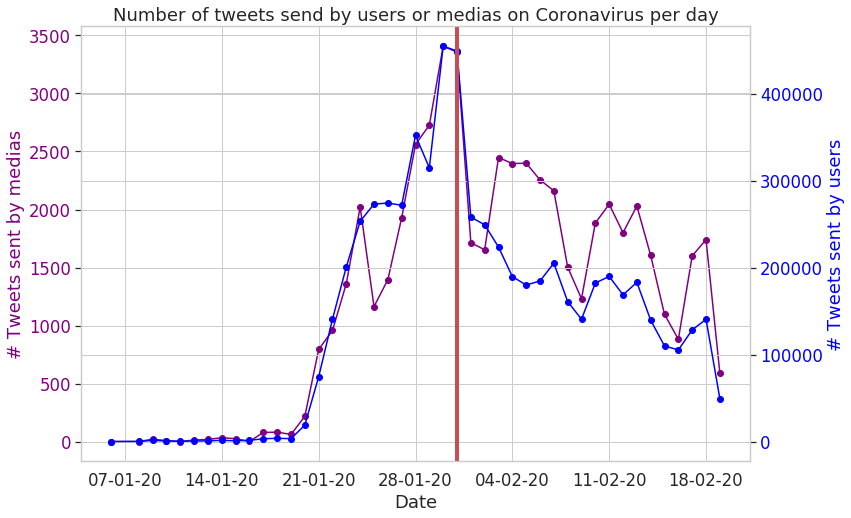

In [9]:
merge = cor_tweets_medias_per_day.merge(cor_tweets_users_per_day, left_on='date', right_on='date', how='inner').fillna(0)
plotTweetPerDay2Axis(merge, "published_x", "published_y", "date", y_1_label="# Tweets sent by medias", y_2_label="# Tweets sent by users", 
                     vertical_line_x="2020-01-31", vertical_line_label="Impeachment")


## Closer look on OMS tweets

## Tweets reactions

## Articles titles analysis

In [9]:
test = pd.read_csv("/mnt/datastore/data/tweets_medias_withURL.csv")
test.count()

tweet_id      54619
user_id       54619
user_name     54616
likes         54616
retweets      54616
text          54616
created_at    54613
url           29324
dtype: int64

## Impeachment

In [177]:
PATH = "/mnt/datastore/data/impeachment"

all_data_imp = pd.DataFrame(columns=[u'author_handle', u'lang', u'likes', u'main', u'permalink',
       u'published', u'replied', u'shared_type', u'shares',
       u'source_followers', u'source_following'])

medias_accounts = pd.read_csv("/mnt/datastore/data/top_twitter_medias.csv", header=None)

all_files = list(os.listdir(PATH))

for i,f in enumerate(all_files):
    print('Loading files %d/%d : %s'%(i+1,len(all_files), f))
    test = pd.read_json(os.path.join(PATH,f), orient="records")
    test = test[test['author_handle'].isin(medias_accounts[0])]
    all_data_imp = pd.concat([all_data_imp, test])
        
print("Done!" + " "*30)
all_data_imp.to_csv("/mnt/datastore/data/tweets_medias_impeachment.csv", encoding='utf-8', index=False)

Loading files 1/508 : 94.json
Loading files 2/508 : 310.json
Loading files 3/508 : 123.json
Loading files 4/508 : 38.json
Loading files 5/508 : 221.json
Loading files 6/508 : 500.json
Loading files 7/508 : 251.json
Loading files 8/508 : 2.json
Loading files 9/508 : 70.json
Loading files 10/508 : 138.json
Loading files 11/508 : 392.json
Loading files 12/508 : 286.json
Loading files 13/508 : 326.json
Loading files 14/508 : 329.json
Loading files 15/508 : 365.json
Loading files 16/508 : 363.json
Loading files 17/508 : 478.json
Loading files 18/508 : 134.json
Loading files 19/508 : 54.json
Loading files 20/508 : 431.json
Loading files 21/508 : 125.json
Loading files 22/508 : 25.json
Loading files 23/508 : 137.json
Loading files 24/508 : 213.json
Loading files 25/508 : 367.json
Loading files 26/508 : 43.json
Loading files 27/508 : 234.json
Loading files 28/508 : 449.json
Loading files 29/508 : 126.json
Loading files 30/508 : 298.json
Loading files 31/508 : 170.json
Loading files 32/508 : 60

Loading files 255/508 : 253.json
Loading files 256/508 : 469.json
Loading files 257/508 : 124.json
Loading files 258/508 : 245.json
Loading files 259/508 : 262.json
Loading files 260/508 : 429.json
Loading files 261/508 : 445.json
Loading files 262/508 : 281.json
Loading files 263/508 : 1.json
Loading files 264/508 : 399.json
Loading files 265/508 : 456.json
Loading files 266/508 : 174.json
Loading files 267/508 : 273.json
Loading files 268/508 : 17.json
Loading files 269/508 : 315.json
Loading files 270/508 : 411.json
Loading files 271/508 : 413.json
Loading files 272/508 : 119.json
Loading files 273/508 : 304.json
Loading files 274/508 : 165.json
Loading files 275/508 : 397.json
Loading files 276/508 : 106.json
Loading files 277/508 : 380.json
Loading files 278/508 : 451.json
Loading files 279/508 : 305.json
Loading files 280/508 : 332.json
Loading files 281/508 : 279.json
Loading files 282/508 : 98.json
Loading files 283/508 : 217.json
Loading files 284/508 : 292.json
Loading files 

Loading files 505/508 : 447.json
Loading files 506/508 : 96.json
Loading files 507/508 : 415.json
Loading files 508/508 : 280.json
Done!                              


In [ ]:
all_data_imp= pd.read_csv("/mnt/datastore/data/tweets_medias_impeachment.csv")
all_data_imp['published'] = pd.to_datetime(all_data_imp['published'], infer_datetime_format=True) 
all_data_imp = groupByDay(all_data_imp, 'published')


In [ ]:
#all_data_imp.dtypes
plotTweetPerDay(all_data_imp[all_data_imp['date'] > "2019-12-31"], "Number of tweet posted by medias on Impeachment per day", 2)